In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10)
from scipy import stats
from scipy.stats import norm, chi2, f
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, het_goldfeldquandt
from sklearn.impute import KNNImputer
import morethemes as mt
mt.set_theme('economist')

In [64]:
ROP = pd.read_csv('data/ROP1.csv')
ROP = ROP.rename(columns={'observation_date': 'Date'})
ROP['Date'] = pd.to_datetime(ROP['Date'])
ROP['Date'] = ROP['Date'].dt.year.astype(str) + 'Q' + ROP['Date'].dt.quarter.astype(str)
ROP = ROP.set_index('Date')
ROP = ROP.rename(columns={'B471RC1Q027SBEA': 'ROP'})
ROP

,ROP
Date,
1947Q1,0.767000
1947Q2,0.767000
1947Q3,0.768000
1947Q4,0.768000
1948Q1,0.803000
...,...
2024Q2,199.358000
2024Q3,199.407000
2024Q4,199.348000


In [65]:
df = pd.read_csv('data/master_quarterly.csv')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index('Date')
df['ROP'] = ROP['ROP']
df['CGDP_change'] = df['CGDP'].diff()
df[['CGDP', 'CGDP_change']].head(10)
df['HP_change'] = df['HP'].diff()
df['IR_change'] = df['IR'].diff()
df['LSOI_change'] = df['LSOI'].diff()
df['INVR'] = df['INVR']/100
df['IROR'] = df['IROR']*1000000
df = df.dropna()
df

,R,CGDP,CPIR,INVR,HP,IR,ROP,IROR,LSOI,RGDP,RGDP.1,MA,TOBQ,CGDP_change,HP_change,IR_change,LSOI_change
Date,,,,,,,,,,,,,,,,,
1970Q3,1.000000,90.600000,1.035375,0.007124,1.561012,5.294625,18.358000,-16.431211,113.180000,5357.077000,0.921467,44.100000,0.629600,0.400000,0.828463,0.014450,-0.520000
1970Q4,0.000000,91.400000,1.451751,-0.025575,1.263789,3.898249,18.701000,-64.103580,113.699000,5299.672000,-1.071573,45.400000,0.684200,0.800000,-0.297223,-1.396375,0.519000
1971Q1,0.000000,90.900000,0.841751,0.016999,2.694829,2.998249,18.799000,126.052571,111.541000,5443.619000,2.716149,51.200000,0.734200,-0.500000,1.431040,-0.900000,-2.158000
1971Q2,0.000000,91.800000,0.918197,0.022017,2.675118,3.331803,18.849000,0.568634,111.502000,5473.059000,0.540817,53.800000,0.720300,0.900000,-0.019711,0.333554,-0.039000
1971Q3,0.000000,92.100000,0.992556,0.012404,1.080599,4.017444,18.937000,7.802701,110.939000,5518.072000,0.822447,55.100000,0.691500,0.300000,-1.594519,0.685641,-0.563000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017Q2,0.000000,153.400000,0.115377,0.020029,1.413681,0.774623,351.937000,5.970152,100.101000,19506.949000,0.559873,57.800000,1.264000,0.700000,0.075611,0.888364,0.380000
2017Q3,0.000000,153.400000,0.478044,0.010460,1.516397,0.561956,351.798000,-21.769587,100.062000,19660.766000,0.788524,60.800000,1.338000,0.000000,0.102717,-0.212667,-0.039000
2017Q4,0.000000,154.100000,0.795531,0.026467,1.587257,0.414469,351.852000,22.488287,100.127000,19882.352000,1.127047,59.300000,1.364000,0.700000,0.070859,-0.147487,0.065000


In [66]:
model1 = (smf.probit('R ~ CGDP_change + CPIR + MA + INVR '
                     '+ HP_change + IR_change', df)
          .fit(data=df))
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.202308
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                      R   No. Observations:                  192
Model:                         Probit   Df Residuals:                      185
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.4630
Time:                        20:33:52   Log-Likelihood:                -38.843
converged:                       True   LL-Null:                       -72.340
Covariance Type:            nonrobust   LLR p-value:                 1.688e-12
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.0362      1.395      2.894      0.004       1.303       6.770
CGDP_change     0.0424    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: data. After release 0.14, this will raise.
  warnings.warn(


In [67]:
model2 = (smf.probit('R ~ CGDP_change + CPIR + MA + INVR '
                     '+ HP_change + ROP', df)
          .fit(data=df))
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.201925
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                      R   No. Observations:                  192
Model:                         Probit   Df Residuals:                      185
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.4641
Time:                        20:33:54   Log-Likelihood:                -38.770
converged:                       True   LL-Null:                       -72.340
Covariance Type:            nonrobust   LLR p-value:                 1.575e-12
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.1864      1.362      2.340      0.019       0.517       5.856
CGDP_change     0.0869    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: data. After release 0.14, this will raise.
  warnings.warn(


In [68]:
model3 = (smf.probit('R ~ CGDP_change + CPIR + MA + INVR '
                     '+ HP_change + IROR', df)
          .fit(data=df))
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.198741
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                      R   No. Observations:                  192
Model:                         Probit   Df Residuals:                      185
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.4725
Time:                        20:33:54   Log-Likelihood:                -38.158
converged:                       True   LL-Null:                       -72.340
Covariance Type:            nonrobust   LLR p-value:                 8.853e-13
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.1586      1.402      2.254      0.024       0.412       5.906
CGDP_change     0.0800    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: data. After release 0.14, this will raise.
  warnings.warn(


In [69]:
model4 = (smf.probit('R ~ CGDP_change + CPIR + MA + INVR '
                     '+ HP_change + LSOI_change', df)
          .fit(data=df))
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.208674
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                      R   No. Observations:                  192
Model:                         Probit   Df Residuals:                      185
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.4461
Time:                        20:33:55   Log-Likelihood:                -40.065
converged:                       True   LL-Null:                       -72.340
Covariance Type:            nonrobust   LLR p-value:                 5.333e-12
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.6446      1.346      2.708      0.007       1.006       6.283
CGDP_change     0.0855    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: data. After release 0.14, this will raise.
  warnings.warn(


In [70]:
model5 = (smf.probit('R ~ CGDP_change + CPIR + MA + INVR '
                     '+ HP_change + TOBQ', df)
          .fit(data=df))
print(model5.summary())

Optimization terminated successfully.
         Current function value: 0.210871
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                      R   No. Observations:                  192
Model:                         Probit   Df Residuals:                      185
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                  0.4403
Time:                        20:33:55   Log-Likelihood:                -40.487
converged:                       True   LL-Null:                       -72.340
Covariance Type:            nonrobust   LLR p-value:                 7.927e-12
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.7299      1.347      2.768      0.006       1.089       6.370
CGDP_change     0.0816    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: data. After release 0.14, this will raise.
  warnings.warn(


In [71]:
coef_dict = {}

for i, model in enumerate([model1, model2, model3, model4, model5], 
                          start=1):
    coef_dict[f'Model {i}'] = model.params

coef_table = pd.DataFrame(coef_dict)

if 'Intercept' in coef_table.index:
    coef_table = coef_table.rename(index={'Intercept': 'Constant'})

order = ['CGDP_change', 'CPIR', 'MA', 'INVR', 'HP_change', 
         'IR_change', 'ROP', 'IROR', 'LSOI_change', 'TOBQ', 
         'Constant']
ordered_index = [var for var in order if var in coef_table.index]
coef_table = coef_table.reindex(ordered_index)

coef_table

,Model 1,Model 2,Model 3,Model 4,Model 5
CGDP_change,0.042399,0.086888,0.079989,0.085499,0.081628
CPIR,0.707364,0.983832,0.808460,0.791329,0.777475
MA,-0.119652,-0.119307,-0.104121,-0.111480,-0.114589
INVR,-16.089632,-18.274907,-20.033631,-22.071476,-19.815263
HP_change,-0.418165,-0.346102,-0.427768,-0.364731,-0.363364
IR_change,-0.311307,NaN,NaN,NaN,NaN
ROP,NaN,0.003692,NaN,NaN,NaN
IROR,NaN,NaN,-0.009269,NaN,NaN
LSOI_change,NaN,NaN,NaN,0.136152,NaN
TOBQ,NaN,NaN,NaN,NaN,0.079679


In [72]:
me_dict = {}

for i, model in enumerate([model1, model2, model3, model4, model5], 
                          start=1):
    me = model.get_margeff()
    me_summary = me.summary_frame()
    me_dict[f'Model {i}'] = me_summary['dy/dx']

me_table = pd.DataFrame(me_dict)

order = ['CGDP_change', 'CPIR', 'MA', 'INVR', 'HP_change', 
         'IR_change', 'ROP', 'IROR', 'LSOI_change', 'TOBQ']
ordered_index = [var for var in order if var in me_table.index]
me_table = me_table.reindex(ordered_index)

coef_separator = pd.DataFrame([['Coefficients'] * 5], 
                              columns=coef_table.columns, 
                              index=[''])
me_separator = pd.DataFrame([['Marginal Effects'] * 5], 
                            columns=me_table.columns, 
                            index=[''])

combined_table = pd.concat([coef_separator, coef_table, 
                           me_separator, me_table])

combined_table

,Model 1,Model 2,Model 3,Model 4,Model 5
,Coefficients,Coefficients,Coefficients,Coefficients,Coefficients
CGDP_change,0.042399,0.086888,0.079989,0.085499,0.081628
CPIR,0.707364,0.983832,0.808460,0.791329,0.777475
MA,-0.119652,-0.119307,-0.104121,-0.111480,-0.114589
INVR,-16.089632,-18.274907,-20.033631,-22.071476,-19.815263
HP_change,-0.418165,-0.346102,-0.427768,-0.364731,-0.363364
IR_change,-0.311307,NaN,NaN,NaN,NaN
ROP,NaN,0.003692,NaN,NaN,NaN
IROR,NaN,NaN,-0.009269,NaN,NaN
LSOI_change,NaN,NaN,NaN,0.136152,NaN


In [75]:

stats_dict = {}

for i, model in enumerate([model1, model2, model3, model4, model5], 
                          start=1):
    
    predictions = model.predict()
    actual = model.model.endog
    
    n_actual_recession = (actual == 1).sum()
    n_actual_non_recession = (actual == 0).sum()
    n_total = len(actual)
    
    pred_50 = (predictions >= 0.5).astype(int)
    correct_recession_50 = ((pred_50 == 1) & (actual == 1)).sum() / n_actual_recession
    correct_non_recession_50 = ((pred_50 == 0) & (actual == 0)).sum() / n_actual_non_recession
    correct_overall_50 = (pred_50 == actual).sum() / n_total
    
    pred_1216 = (predictions >= 0.1216).astype(int)
    correct_recession_1216 = ((pred_1216 == 1) & (actual == 1)).sum() / n_actual_recession
    correct_non_recession_1216 = ((pred_1216 == 0) & (actual == 0)).sum() / n_actual_non_recession
    correct_overall_1216 = (pred_1216 == actual).sum() / n_total
    
    stats_dict[f'Model {i}'] = {
        'Observations': int(model.nobs),
        'Pseudo R²': model.prsquared,
        'AIC': model.aic,
        'BIC': model.bic,
        'Log-Likelihood': model.llf,
        'LLR p-value': model.llr_pvalue,
        'Correct Recession (50%)': correct_recession_50,
        'Correct Non-Recession (50%)': correct_non_recession_50,
        'Correct Overall (50%)': correct_overall_50,
        'Correct Recession (12.16%)': correct_recession_1216,
        'Correct Non-Recession (12.16%)': correct_non_recession_1216,
        'Correct Overall (12.16%)': correct_overall_1216
    }

stats_table = pd.DataFrame(stats_dict).T
stats_table = stats_table.T

pd.options.display.float_format = '{:.6f}'.format

stats_table

,Model 1,Model 2,Model 3,Model 4,Model 5
Observations,192.000000,192.000000,192.000000,192.000000,192.000000
Pseudo R²,0.463046,0.464064,0.472514,0.446150,0.440319
AIC,91.686322,91.539050,90.316593,94.130885,94.974496
BIC,114.488789,114.341517,113.119061,116.933352,117.776964
Log-Likelihood,-38.843161,-38.769525,-38.158297,-40.065442,-40.487248
LLR p-value,0.000000,0.000000,0.000000,0.000000,0.000000
Correct Recession (50%),0.583333,0.500000,0.500000,0.458333,0.416667
Correct Non-Recession (50%),0.988095,0.982143,0.970238,0.982143,0.982143
Correct Overall (50%),0.937500,0.921875,0.911458,0.916667,0.911458
Correct Recession (12.16%),0.833333,0.875000,0.958333,0.916667,0.916667


In [ ]:
stats_separator = pd.DataFrame([['Model Statistics'] * 5], 
                               columns=stats_table.columns, 
                               index=[''])

final_table = pd.concat([combined_table, stats_separator, stats_table])

final_table

,Model 1,Model 2,Model 3,Model 4,Model 5
,Coefficients,Coefficients,Coefficients,Coefficients,Coefficients
CGDP_change,0.042399,0.086888,0.079989,0.085499,0.081628
CPIR,0.707364,0.983832,0.808460,0.791329,0.777475
MA,-0.119652,-0.119307,-0.104121,-0.111480,-0.114589
INVR,-16.089632,-18.274907,-20.033631,-22.071476,-19.815263
HP_change,-0.418165,-0.346102,-0.427768,-0.364731,-0.363364
IR_change,-0.311307,NaN,NaN,NaN,NaN
ROP,NaN,0.003692,NaN,NaN,NaN
IROR,NaN,NaN,-0.009269,NaN,NaN
LSOI_change,NaN,NaN,NaN,0.136152,NaN


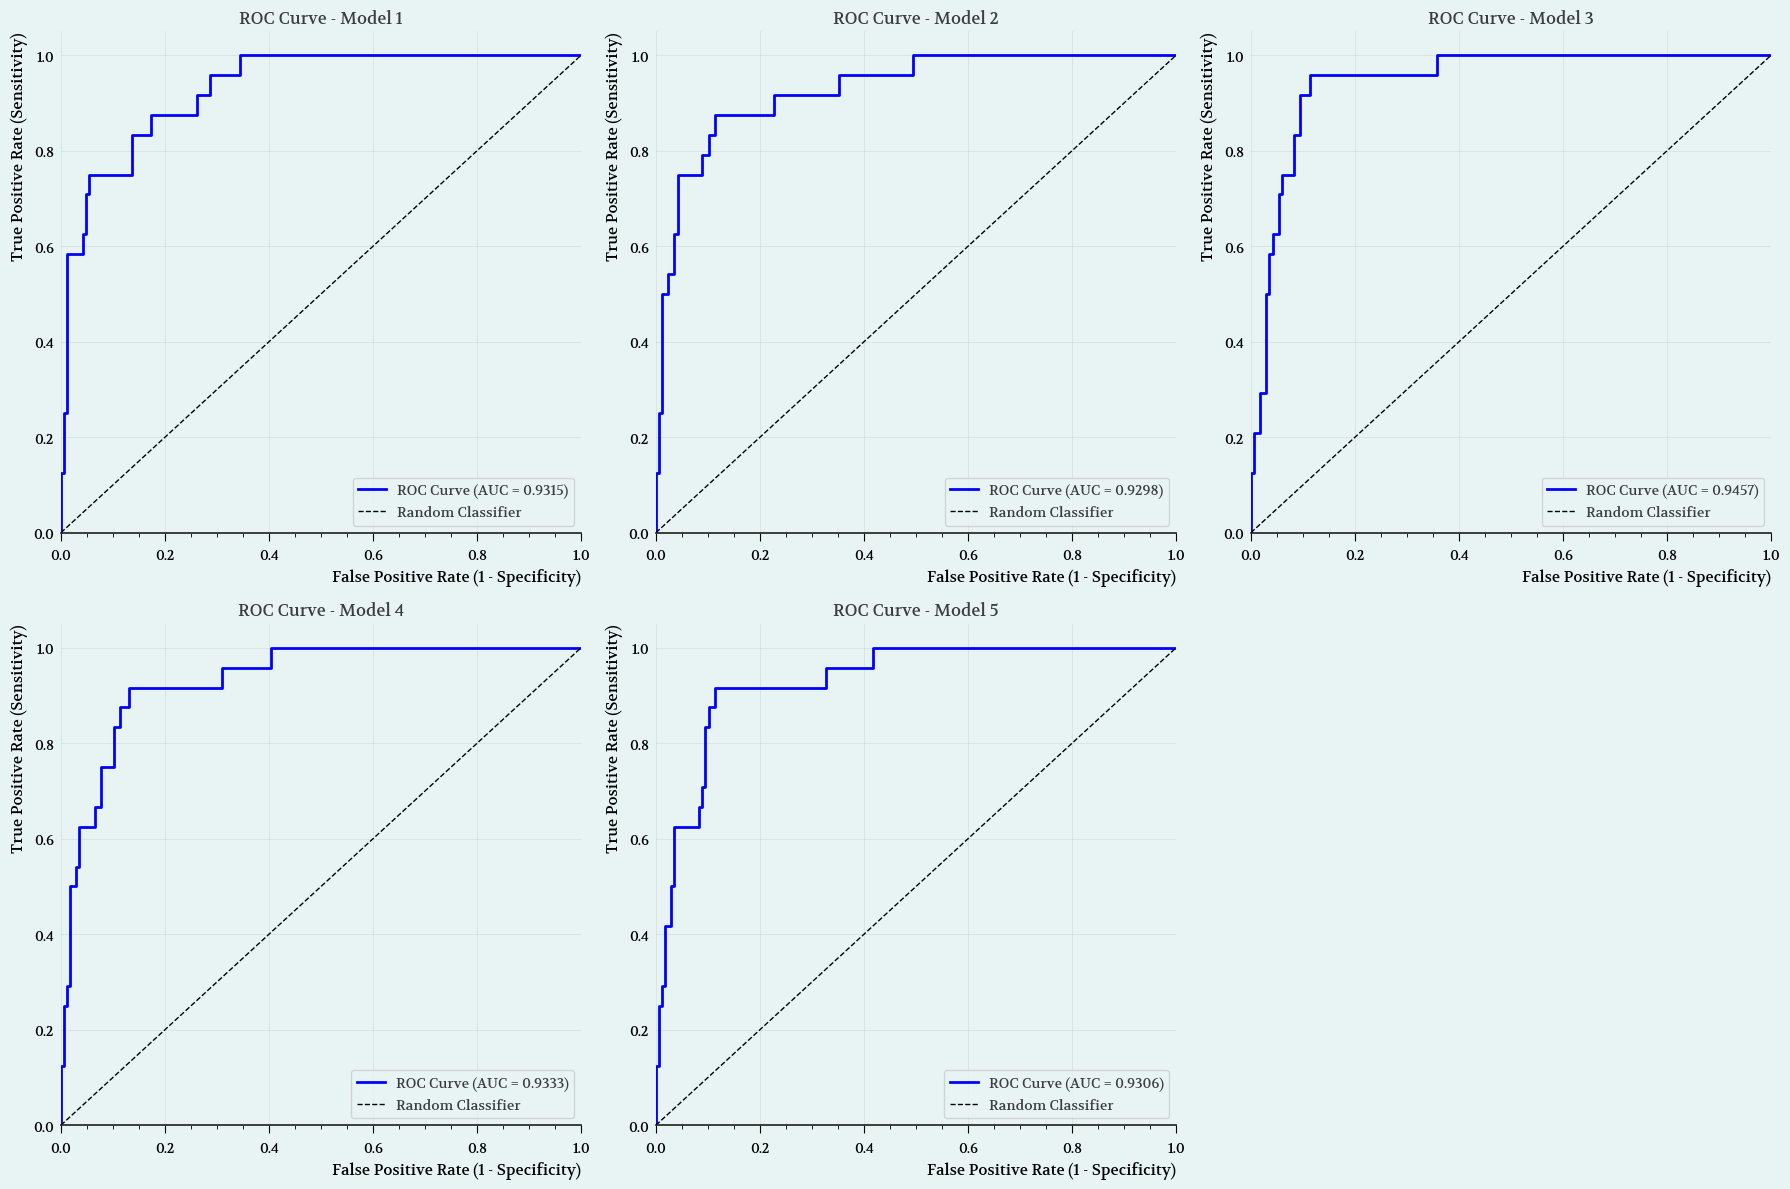

Area Under the Curve (AUC) for each model:
Model 1: 0.9315
Model 2: 0.9298
Model 3: 0.9457
Model 4: 0.9333
Model 5: 0.9306


In [77]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

models = [model1, model2, model3, model4, model5]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

for idx, (model, name) in enumerate(zip(models, model_names)):

    predictions = model.predict()
    actual = model.model.endog

    fpr, tpr, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(fpr, tpr)
    

    axes[idx].plot(fpr, tpr, color='blue', linewidth=2, 
                   label=f'ROC Curve (AUC = {roc_auc:.4f})')
    axes[idx].plot([0, 1], [0, 1], color='black', linewidth=1, 
                   linestyle='--', label='Random Classifier')
    axes[idx].set_xlim([0.0, 1.0])
    axes[idx].set_ylim([0.0, 1.05])
    axes[idx].set_xlabel('False Positive Rate (1 - Specificity)', 
                         fontsize=11)
    axes[idx].set_ylabel('True Positive Rate (Sensitivity)', fontsize=11)
    axes[idx].set_title(f'ROC Curve - {name}', fontsize=12, 
                       fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

print("Area Under the Curve (AUC) for each model:")
for model, name in zip(models, model_names):
    predictions = model.predict()
    actual = model.model.endog
    fpr, tpr, _ = roc_curve(actual, predictions)
    roc_auc = auc(fpr, tpr)
    print(f'{name}: {roc_auc:.4f}')

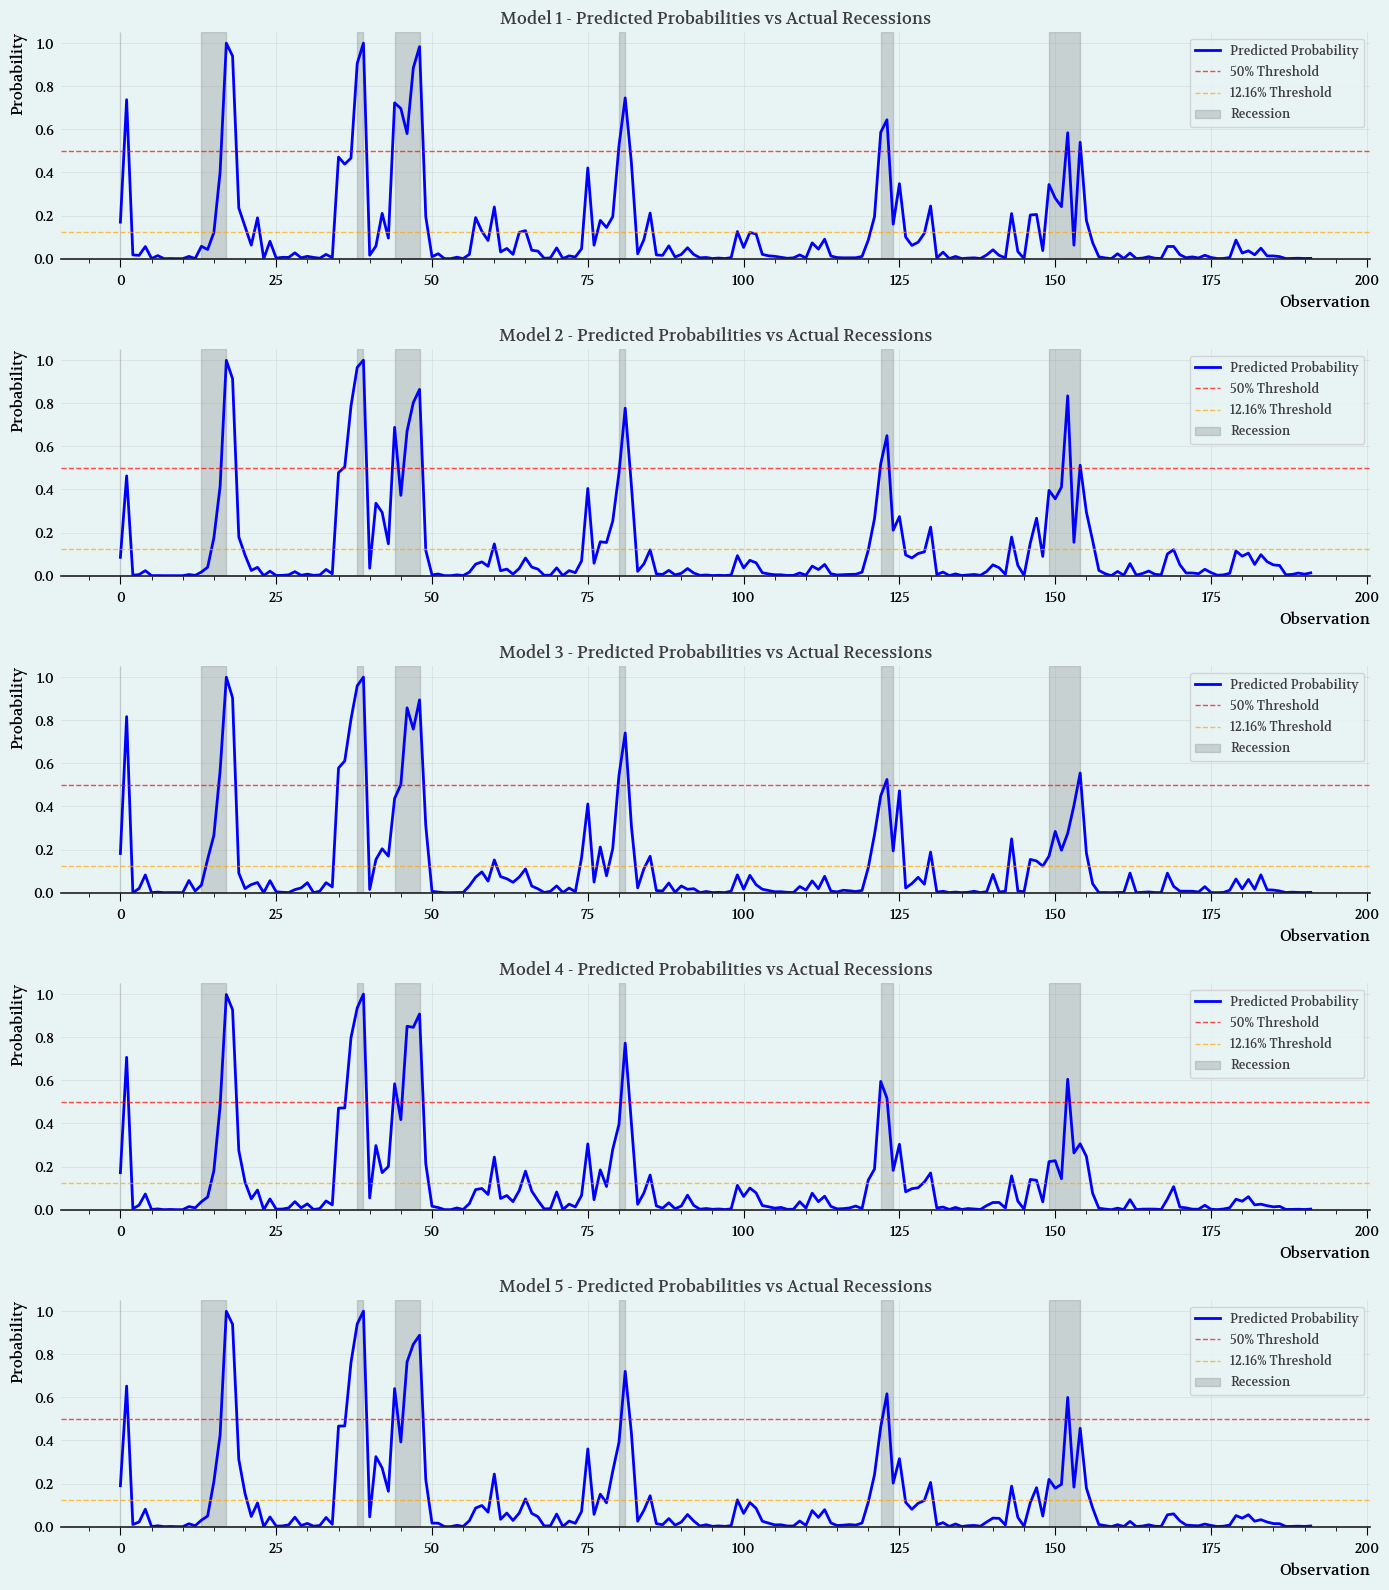

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(14, 16))

models = [model1, model2, model3, model4, model5]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

for idx, (model, name) in enumerate(zip(models, model_names)):
    predictions = model.predict()
    actual = model.model.endog
    
    x = np.arange(len(predictions))
    
    axes[idx].plot(x, predictions, color='blue', linewidth=2, 
                   label='Predicted Probability')
    axes[idx].axhline(y=0.5, color='red', linestyle='--', 
                     linewidth=1, alpha=0.7, label='50% Threshold')
    axes[idx].axhline(y=0.1216, color='orange', linestyle='--', 
                     linewidth=1, alpha=0.7, label='12.16% Threshold')
    
    in_recession = False
    recession_start = None
    first_recession = True
    
    for i in range(len(actual)):
        if actual[i] == 1 and not in_recession:
            recession_start = i
            in_recession = True
        elif actual[i] == 0 and in_recession:
            axes[idx].axvspan(recession_start, i-1, alpha=0.3, 
                            color='gray', 
                            label='Recession' if first_recession else '')
            in_recession = False
            first_recession = False
    
    if in_recession:
        axes[idx].axvspan(recession_start, len(actual)-1, alpha=0.3, 
                        color='gray', 
                        label='Recession' if first_recession else '')
    
    axes[idx].set_xlabel('Observation', fontsize=11)
    axes[idx].set_ylabel('Probability', fontsize=11)
    axes[idx].set_title(
        f'{name} - Predicted Probabilities vs Actual Recessions', 
        fontsize=12, 
        fontweight='bold'
    )
    axes[idx].set_ylim([0, 1.05])
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.show()
plt.tight_layout()

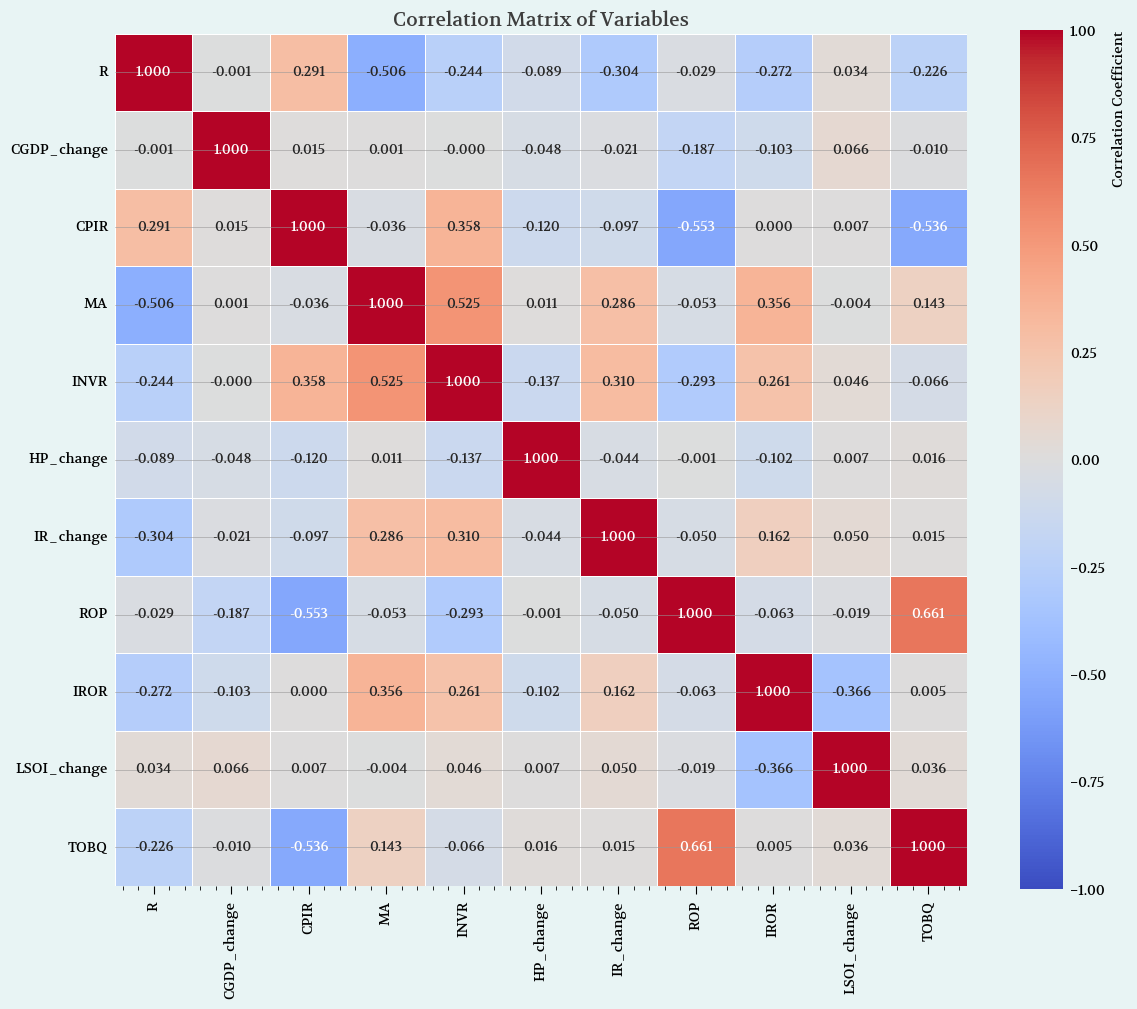

,R,CGDP_change,CPIR,MA,INVR,HP_change,IR_change,ROP,IROR,LSOI_change,TOBQ
R,1.000000,-0.001056,0.290738,-0.505698,-0.244419,-0.088995,-0.303924,-0.029217,-0.271691,0.034273,-0.225952
CGDP_change,-0.001056,1.000000,0.014792,0.001300,-0.000196,-0.048333,-0.020768,-0.186810,-0.102512,0.066060,-0.009847
CPIR,0.290738,0.014792,1.000000,-0.036241,0.357686,-0.120497,-0.096872,-0.553405,0.000207,0.006828,-0.536293
MA,-0.505698,0.001300,-0.036241,1.000000,0.525324,0.010575,0.286177,-0.053226,0.355546,-0.004334,0.142848
INVR,-0.244419,-0.000196,0.357686,0.525324,1.000000,-0.137223,0.309785,-0.292862,0.261029,0.046208,-0.066241
HP_change,-0.088995,-0.048333,-0.120497,0.010575,-0.137223,1.000000,-0.044169,-0.000690,-0.101627,0.007121,0.016124
IR_change,-0.303924,-0.020768,-0.096872,0.286177,0.309785,-0.044169,1.000000,-0.049606,0.162384,0.049861,0.014626
ROP,-0.029217,-0.186810,-0.553405,-0.053226,-0.292862,-0.000690,-0.049606,1.000000,-0.062535,-0.018643,0.660691
IROR,-0.271691,-0.102512,0.000207,0.355546,0.261029,-0.101627,0.162384,-0.062535,1.000000,-0.365802,0.004966
LSOI_change,0.034273,0.066060,0.006828,-0.004334,0.046208,0.007121,0.049861,-0.018643,-0.365802,1.000000,0.035967


In [78]:
variables = [
    'R', 'CGDP_change', 'CPIR', 'MA', 'INVR', 'HP_change', 
    'IR_change', 'ROP', 'IROR', 'LSOI_change', 'TOBQ'
]

correlation_matrix = df[variables].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt='.3f', 
    cmap='coolwarm', 
    center=0,
    vmin=-1, 
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix of Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

correlation_matrix

In [ ]:
from scipy.stats import norm

variables = ['CPIR', 'MA', 'HP_change', 'ROP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(variables):
    var_range = np.linspace(df[var].min(), df[var].max(), 200)
    
    marginal_effects = []
    ci_lower_list = []
    ci_upper_list = []
    
    var_idx = list(model2.model.exog_names).index(var)
    coef = model2.params.iloc[var_idx]
    
    for val in var_range:
        X_row = []
        X_row.append(1)
        for col in model2.model.exog_names[1:]:
            if col == var:
                X_row.append(val)
            else:
                X_row.append(df[col].mean())
        
        X_row = np.array(X_row)
        fitted = np.dot(X_row, model2.params.values)
        pdf_val = norm.pdf(fitted)
        
        me = coef * pdf_val
        marginal_effects.append(me)
        
        vcov = model2.cov_params()
        se = np.sqrt(vcov.iloc[var_idx, var_idx]) * pdf_val
        ci_lower_list.append(me - 1.96 * se)
        ci_upper_list.append(me + 1.96 * se)
    
    marginal_effects = np.array(marginal_effects)
    ci_lower = np.array(ci_lower_list)
    ci_upper = np.array(ci_upper_list)
    
    axes[idx].plot(var_range, marginal_effects, color='blue', 
                   linewidth=2, label='Marginal Effect')
    axes[idx].fill_between(var_range, ci_lower, ci_upper, 
                           alpha=0.3, color='gray', label='95% CI')
    axes[idx].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[idx].set_xlabel(var, fontsize=11)
    axes[idx].set_ylabel('Marginal Effect', fontsize=11)
    axes[idx].set_title(f'Marginal Effect of {var}', fontsize=12, 
                       fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()